In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.functional as F

from options import Options
from models import *
from dataset import *
from utils import *

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [14]:
print(os.listdir('models'))
# Change this
model_folder = f"models/RobertaCombinedModel_finetune/"

['.ipynb_checkpoints', 'BERTCombinedModel_finetune', 'RobertaCombinedModel_finetune']


In [22]:
opt = Options()
opt.load_options(model_folder)

state = torch.load(f"{model_folder}/best.pth")
history = torch.load(f"{model_folder}/history.pth")

Dataset = Datasets[opt.dataset]
model = Models[opt.model](opt).to(device)

test_df = pd.read_csv(f"{opt.data_folder}/test.csv")
test_set = Dataset(test_df, opt)
test_loader = DataLoader(test_set, batch_size=30, shuffle=False)

model.load_state_dict(state['state_dict'])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

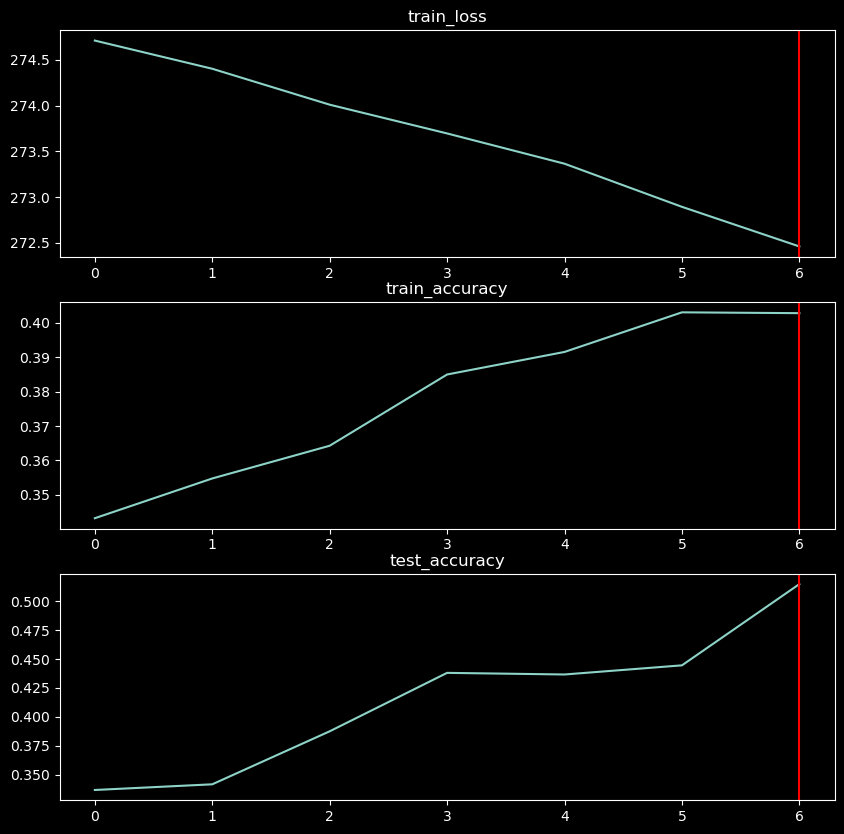

In [23]:
# model = model.to(device)
fig, axs = plt.subplots(len(history),1,figsize=(10,10))
test_best = state['epoch']

for i, key in enumerate(history.keys()):
    ax = axs[i]
    ax.set_title(key)

    ax.plot(history[key])
    ax.axvline(test_best, color='red')

In [17]:
# Confusion matrix and accuracies
y_pred, y_test, test_accuracy = predict(model, test_loader)
print(test_accuracy)

0.4445


In [18]:
y_pred, y_test = torch.tensor(y_pred).detach().numpy(), torch.tensor(y_test).detach().numpy()

In [19]:
# Succ
test_df['y_pred'] = y_pred
test_df['y_test'] = y_test
test_df.loc[y_pred==y_test, ['sentence1', 'sentence2', 'gold_label', 'y_test', 'y_pred']]

,sentence1,sentence2,gold_label,y_test,y_pred
1,A brown dog and black and white dog run along ...,Two squirrels run after acorns in the grass.,contradiction,0,0
3,An old Indian man dressed in rags sleeps on th...,An old Indian man is dressed up,contradiction,0,0
6,Many people gathered in a room with several pe...,Parents gathers for a local high school concert,neutral,1,1
7,A gray-haired man rides a bike in front of a b...,An older man rides his bike and is almost hit ...,neutral,1,1
11,"A woman in a blue uniform, with long curly red...",The horse is dead.,contradiction,0,0
...,...,...,...,...,...
9983,Two men heavily immersed in a conversation wor...,The men are at work.,-,0,0
9989,A person in a red jacket and a red hard hat st...,A person is situated near a mountain.,entailment,2,2
9990,"two girls looking out the window at ""Hair at H...",Two people look out a window.,entailment,2,2
9992,An older man is speaking to a boy while both a...,Older man is sleeping,contradiction,0,0


In [20]:
# Fails
test_df.loc[y_pred!=y_test, ['sentence1', 'sentence2', 'gold_label', 'y_test', 'y_pred']]

,sentence1,sentence2,gold_label,y_test,y_pred
0,A kid bored in a train with brown hair and his...,A child is riding the train from New York to B...,neutral,1,0
2,A person in full astronaut suit and gear train...,A female astronaut adjusting to the feeling of...,neutral,1,2
4,A bunch of people are standing all together in...,A group of people are planning something.,neutral,1,0
5,"Two girls (one dressed in blue, and one dresse...",The winner gets a free soda.,neutral,1,0
8,Two men in black jackets behind a white handrail.,The two men are friends,neutral,1,0
...,...,...,...,...,...
9995,Man sitting playing guitar.,A man is sitting and strumming a guitar.,entailment,2,0
9996,Two women stand in the street both wearing mat...,Two women are dancing in the street wearing dr...,neutral,1,2
9997,This person looks to be snowboarding on a very...,Young snowboarder sizing up their next jump,entailment,2,1
9998,A group of cleaners are sweeping up animal fec...,A group of cleaners after a parade.,entailment,2,1


              precision    recall  f1-score   support

           0       0.40      0.89      0.55      3413
           1       0.51      0.14      0.22      3219
           2       0.61      0.29      0.39      3368

    accuracy                           0.44     10000
   macro avg       0.51      0.44      0.39     10000
weighted avg       0.51      0.44      0.39     10000



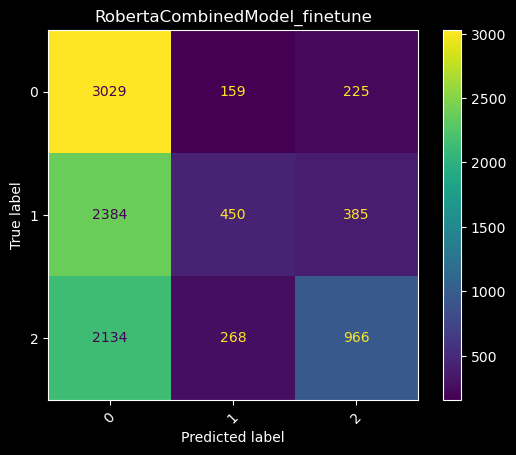

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.xticks(rotation = 45)
plt.title(f"{model_folder.split('/')[1]}")
print(classification_report(y_test, y_pred))